In [1]:

import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
#import tools4pyPhysChem as t4pPC
import tools4PytChem as t4p

**Start at:** Saturday 18 November 2023, 22:09:47  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# <!-- TITLE --> MOLECULAR DYNAMICS - VELOCITY VERLET ALGORITHM

## Introduction

<div class="intro">

This computer lab deal with Classical molecular dynamics. In the context of theoretical chemistry, classical molecular dynamic is a computational method that allows study the motion of atoms or molecule under the influence of a specific potential. The principle of molecular dynamic is to solve Newton’s equations of motions in order to simulate the dynamical behaviour of nuclei.
    
The principle of classical molecular dynamics is to solve Newton's equations to model the dynamic behavior of nuclei. In order to calculate the positions of atoms at a given time, it is necessary to use a "propagator". Of the many propagators available, the "Velocity-Verlet" type is among the most widely used. In this case, positions and velocities are propagated over time according to the following equations.
\begin{align}    
\mathbf{x(t+\delta t)=x(t)+v_x(t).\delta t+\frac{1}{2} \gamma(t).\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_x(t+\delta t)=v_x(t)+\frac{\gamma(t)+\gamma(t+δt)}{2}.\delta t} \\
\end{align}
    
whith $v(t)$, the velocity (first derivatives of positions with respect to time) and $\gamma (t)$, the acceleration (second derivatives of positions with respect to time).
    
To determine accelerations, we use Newton's law, which relates acceleration to force and thus to the energy gradient.
    
\begin{align}
\vec{\gamma}(t) & = \frac{\vec{F}(t)}{M} \\
\end{align}
    
    
\begin{align}
\vec{F}(t)&=-\vec{\nabla}_x{\mathbf{V(x(t))}}&= -\frac{\partial V(x(t))}{\partial x} \\
\end{align}
    
Initial conditions ($x(t=0)$ and $v(t=0)$) and a potential function are therefore required to achieve dynamics. The propagation of positions and velocities is iterative. By rewriting the "velocity verlet" equations considering t=0, the positions and velocities calculated for δt will become the positions and velocities at t=0 for the next point and so on....
For this project, we'll consider a particle of mass 1 moving on a one-dimensional model potential (the generalisation to two- or more-dimension is straitforward)

</div>



## Definition of the differents potentials

<div class="rqT" title="Directives">
    
- It is necessary to define model potentials before performing MD simulations
- These potentials and the associated forces must be defined using symbolic algebra and may need the SymPy module
</div>


<u>One-dimensional model potentials considered</u>:
    
    
**Harmonic potential**: $$ V(x)=k.(x-x_e)^2 $$


**Morse Potential**: $$V(x)=D_e.(1-e^{-\alpha(x-x_e)})^2$$


**Double_well potential**: $$ V(x)=\frac{1}{2}(f_1(x)+f_2(x))-\frac{1}{2}\sqrt{(f_1(x)-f_2(x))^2+h^2} $$

with $$ f_i(x)=k_i.(x-x_{ei})^2 + V_i $$

    



In [2]:
import sympy as sym
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<div class="rqT" title="Directives">
    
- Each potential can be characterized by several parameters, which need to be defined beforehand. 
</div>

In [3]:
#Define parameters for potentials:
m = 1       # mass of the particle
xe_1 = 0    # Equilibrium distance for harmonic, Morse and double well potentials
xe_2 = -2   # Equilibrium distance for double well potential only

k_1 =  2    # Force constant for harmonic and double well potentials
k_2 =  2    # Force constant for double well potential only

alpha = 0.05     # Parameter for Morse potentia
De = 2           # Prefactor for Morse potential

V_1 =  0      # Translation of potential (1) for double well potential
V_2 =  0      # Translation of potential (2) for double well potential

h = 2         # Coupling term for double well potential

<div class="exE">

- To simplify the switch between potentials, define three differents function as a function of x, one for each potential
- <b/>Forces</b> are a point of utmost importance of the algorithm. Define a function to calculate forces for a selected potential
- Display the analytic expression of the selected potential and associated forces
- Plot the selected potential as a function of the variable 'x' (You may need to use the lambdify function in the SymPy module to calculate a numerical value). 
    
</div>

Harmonic potential:


2*x**2

Harmonic potential force:


-4*x

Morse potential:


2*(1 - exp(-0.05*x))**2

Morse potential force:


-0.2*(1 - exp(-0.05*x))*exp(-0.05*x)

Double_well potential:


1.0*x**2 + 1.0*(x + 2)**2 - 0.5*sqrt((2*x**2 - 2*(x + 2)**2)**2 + 4)

Double_well potential force:


-4.0*x + 0.5*(-16*x**2 + 16*(x + 2)**2)/sqrt((2*x**2 - 2*(x + 2)**2)**2 + 4) - 4.0

Text(0.5, 1.0, 'Potentials vs. $x$')

Text(0.5, 0, '$x$')

Text(0, 0.5, 'V')

<function matplotlib.pyplot.show(close=None, block=None)>

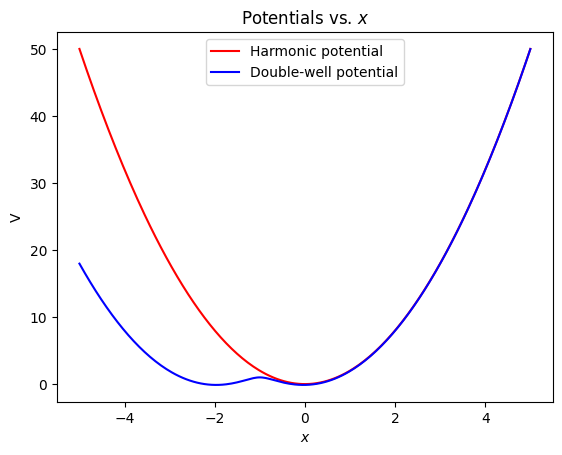

In [9]:
#insert your code here


def hpot(x):
    """
    This function calculates the harmonic potential
   
    It receives as input:
    -the position x

    As output, it returns the harmonic potential
    """
    V=k_1*(x-xe_1)**2
    return V

def mpot(x):
    """
    This function calculates the morse potential
   
    It receives as input:
    -the position x

    As output, it returns the morse potential
    """
    V=De*(1-sym.exp(-alpha*(x-xe_1)))**2
    return V

def dwpot(x):
    """
    This function calculates the double-well potential
   
    It receives as input:
    -the position x

    As output, it returns the double-well potential
    """
    f1=(k_1*(x-xe_1)**2)+V_1
    f2=(k_2*(x-xe_2)**2)+V_2
    V=((1/2)*(f1+f2))-(1/2)*sym.sqrt(((f1-f2)**2)+h**2)
    return V

def force(V,x):
    """
    This function calculates the force of a potential
   
    It receives as input:
    -the potential V
    -the position x

    As output, it returns the force
    """
    F=-sym.diff(V, x)
    return F

x = sym.symbols('x')

#printing the analytic expressions of the potentials
print("Harmonic potential:")
hpot(x)
print("Harmonic potential force:")
force(hpot(x),x)
print("Morse potential:")
mpot(x)
print("Morse potential force:")
force(mpot(x),x)
print("Double_well potential:")
dwpot(x)
print("Double_well potential force:")
force(dwpot(x),x)

_hpot=sym.lambdify([x], hpot(x))
_mpot=sym.lambdify([x], mpot(x))
_dwpot=sym.lambdify([x], dwpot(x))

#plotting the potentials as a function of 'x'
_x = np.linspace(-5.,5.,250)
plt.plot(_x, _hpot(_x), color='red', label="Harmonic potential")
plt.title('Potentials vs. $x$')
plt.xlabel("$x$")
plt.ylabel("V")
plt.plot(_x, _dwpot(_x), color='blue', label="Double-well potential")
plt.legend()
plt.show





Text(0.5, 1.0, 'Potential vs. $x$')

Text(0.5, 0, '$x$')

Text(0, 0.5, '$V_{morse}$')

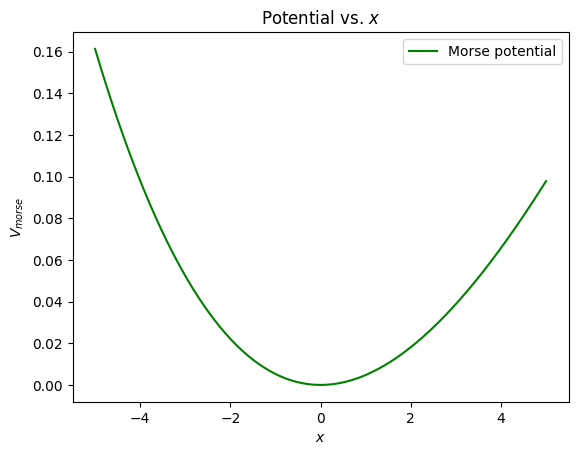

In [8]:
#due to scaling differences, doing another plot for the morse potential
plt.title('Potential vs. $x$')
plt.xlabel("$x$")
plt.ylabel("$V_{morse}$")
plt.plot(_x, _mpot(_x), color='green', label="Morse potential")
plt.legend()
plt.show()

## Velocity Verlet Algorithm

<div class="rqT" title="Directives">
    
- Several parameters must be defined to control the MD simulation:
    - step time <b/> δt</b>     
    - Total time or number of steps 
    - The initial position and initial velocity
- <b/>Total energy</b>, defined in the context of Hamiltonian mechanics, is a constant. It must be calculated for each time step in order to check that the algorithm behaves correctly. 
- You will need to use the lambdify function in the SymPy module to calculate a numerical force value for each position.  

</div>

<div class="exE">

- Define the variables that describe the parameters of the MD simulation (initial time will be set to 0)
- Use a loop to implement the velocity verlet algorithm
    - Defining functions for updating positions and speeds can be useful but is not mandatory
- For each step (including the initial step), record in separate tables (or in a single file)
    - Time
    - Position
    - Velocity
    - Energy (i.e value of the potential)
    - Total energy
    
    
</div>

In [25]:
# insert your code here

#defining the variables
t=0 #initial time
delta_t=0.05 #time increment
total_t=5 #total time of the simulation
x_t0=0.1 #initial position
v_t0=0.1 #initial velocity
x_t=0.1 #position on time t
v_t=0.1 #velocity on time t


def e_tot(v,V):
    """
    This function calculates the total energy of a given potential at a given velocity
   
    It receives as input:
    -the velocity v
    -the potential V

    As output, it returns the total energy
    """
    p=m*v
    E=(p**2/(2*m))+V
    return E

def pos(t):
    """
    This function calculates the position at a given time
   
    It receives as input:
    -the time t

    As output, it returns the position according to the Velocity-Verlet algorithm
    """
    return x_t0+(v_t*delta_t)+((1/2)*gama_t0r*(delta_t)**2)

def vel(t):
    """
    This function calculates the velocity at a given time
   
    It receives as input:
    -the time t

    As output, it returns the velocity according to the Velocity-Verlet algorithm
    """
    return v_t0+(((gama_t0r+gama_tr)/2)*delta_t)

V=hpot #choosing a potential

if V == hpot:
    Vi = "Harmonic potential"
elif V == mpot:
    Vi = "Morse potential"
elif V == dwpot:
    Vi = "Double-well potential"
else:
    print("Error")

print(f"The choosing potential was: {Vi}\n\n")


#creating lists to store the values
time=[]
position=[]
velocity=[]
energy_pot=[]
energy_tot=[]




#loop to calculate and store the values

while t<=total_t:
    time.append(t)
    position.append(x_t)
    velocity.append(v_t)
    energy_pot.append(V(x_t))
    energy_tot.append(e_tot(v_t,V(x_t)))
    #calculating the acceleration on t
    gama_t0=(force(V(x),x)/m)
    gama_t0r=gama_t0.subs({x:x_t})
    print(f"t= {t:.2f}")
    print(f"Position: {x_t:.3f}")
    print(f"Velocity: {v_t:.3f}")
    print(f"Energy (potential): {V(x_t):.3f}")
    print(f"Total energy: {e_tot(v_t,V(x_t)):.3f}\n\n")
    x_t=pos(t)
    x_t0=x_t
    #calculating the acceleration on t+delta_t
    gama_t=(force(V(x),x)/m)
    gama_tr=gama_t.subs({x:x_t})
    v_t=vel(t)
    v_t0=v_t
    t=t+delta_t

#setting precision to 3 decimals
position3 = ["{:.3f}".format(value) for value in position]
velocity3 = ["{:.3f}".format(value) for value in velocity]
energy_pot3 = ["{:.3f}".format(value) for value in energy_pot]
energy_tot3 = ["{:.3f}".format(value) for value in energy_tot]



#creating a table
df = pd.DataFrame(list(zip(time, position3, velocity3, energy_pot3, energy_tot3)),
               columns =['time', 'position', 'velocity', 'energy (potential)', 'total energy'])
#showing the table
df


The choosing potential was: Harmonic potential


t= 0.00
Position: 0.100
Velocity: 0.100
Energy (potential): 0.020
Total energy: 0.025


t= 0.05
Position: 0.104
Velocity: 0.080
Energy (potential): 0.022
Total energy: 0.025


t= 0.10
Position: 0.108
Velocity: 0.058
Energy (potential): 0.023
Total energy: 0.025


t= 0.15
Position: 0.110
Velocity: 0.036
Energy (potential): 0.024
Total energy: 0.025


t= 0.20
Position: 0.112
Velocity: 0.014
Energy (potential): 0.025
Total energy: 0.025


t= 0.25
Position: 0.112
Velocity: -0.008
Energy (potential): 0.025
Total energy: 0.025


t= 0.30
Position: 0.111
Velocity: -0.030
Energy (potential): 0.025
Total energy: 0.025


t= 0.35
Position: 0.109
Velocity: -0.052
Energy (potential): 0.024
Total energy: 0.025


t= 0.40
Position: 0.106
Velocity: -0.074
Energy (potential): 0.022
Total energy: 0.025


t= 0.45
Position: 0.101
Velocity: -0.094
Energy (potential): 0.021
Total energy: 0.025


t= 0.50
Position: 0.096
Velocity: -0.114
Energy (potential): 0.018

,time,position,velocity,energy (potential),total energy
0,0.00,0.100,0.100,0.020,0.025
1,0.05,0.104,0.080,0.022,0.025
2,0.10,0.108,0.058,0.023,0.025
3,0.15,0.110,0.036,0.024,0.025
4,0.20,0.112,0.014,0.025,0.025
...,...,...,...,...,...
96,4.80,-0.107,-0.063,0.023,0.025
97,4.85,-0.110,-0.041,0.024,0.025
98,4.90,-0.111,-0.019,0.025,0.025
99,4.95,-0.112,0.003,0.025,0.025


## Post processing

<div class="rqT" title="Directives">
    
- The advantage of MD simulation is that several parameters are stored (in tables or files) and can be used for post-processing
    
    - To check the validity of the algorithm
    - To calculate mean structural or spectroscopic properties

</div>

<div class="exE">

- To check the validity of the algorithm
    - Plot the stored potentials as a function of stored positions 
    - Plot the stored positions or velocities as a function of time
    - Plot the variation in total energy (as a percentage) as a function of time
- To calculate mean structural or spectroscopic properties
    - Calculate the mean value of the position
    
    
</div>

Text(0.5, 1.0, 'Potential energy vs. position')

<function matplotlib.pyplot.show(close=None, block=None)>

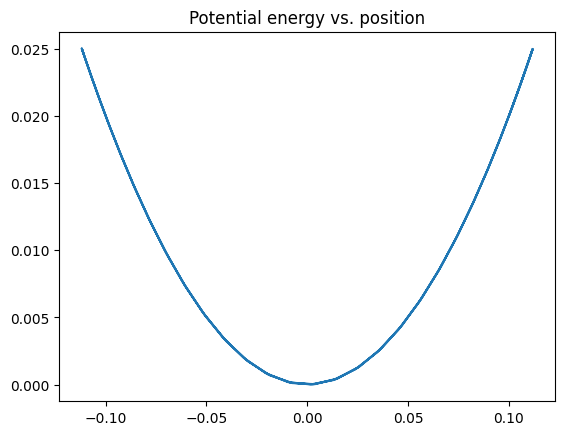

In [26]:
# insert your code here

#plotting potential energy vs. position
plt.plot(position, energy_pot)
plt.title('Potential energy vs. position')
plt.show


Text(0.5, 1.0, 'Position vs. time')

<function matplotlib.pyplot.show(close=None, block=None)>

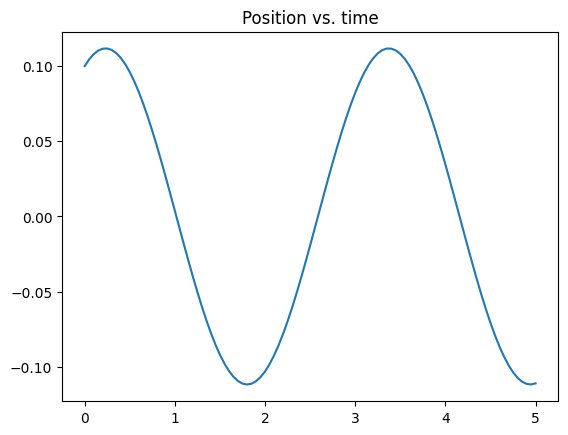

In [27]:
#plotting position vs. time

plt.plot(time, position)
plt.title('Position vs. time')
plt.show

Text(0.5, 1.0, 'Variation in total energy (%) vs. time')

<function matplotlib.pyplot.show(close=None, block=None)>

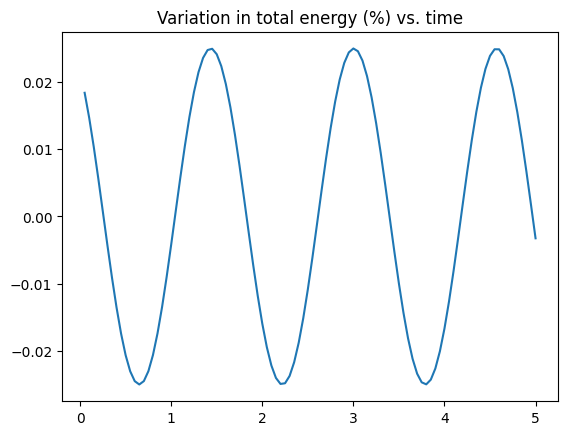

In [29]:
#creating a list to store the percentual variaton in total energy
delta_etot=[]

#loop to store the values
for i in range(0,len(energy_tot)):
    if i != 0: #does not take into account the first position, since there was no variation at this point yet
        delta_e=((energy_tot[i]-energy_tot[i-1])/energy_tot[i-1])*100 #calculates the variation and makes it percentual by multiplying by 100
        delta_etot.append(delta_e) #stores the value

#since the variation in total energy only begins on the second position and two lists need to have the same dimensions to be plotted, we need to remove the 0th value of t
new_time=list(time) #creating a new list for the time
new_time.remove(0) #removing the 0th value

#plotting variation in total energy (%) vs. time
plt.plot(new_time, delta_etot)
plt.title('Variation in total energy (%) vs. time')
plt.show


In [30]:
#Calculating the mean value of the position
def mean_value(l):
    return sum(l)/len(l)

mean=mean_value(position)
print(f"The mean value of the position is: {mean:.3f}")


The mean value of the position is: 0.004


## OPTIONNAL :Beyond the potential of one dimension - 2D potentials

<div class="rqT" title="Directives">
    
- A two-dimensional potential can simply be created by adding a one-dimensional potential along x and another along y, as well as any coupling function between x and y.
    
 $$ V(x,y)=V_1(x)+V_2(y)+f(x,y) $$
    
where $𝑉_1 (𝑥)$ and $𝑉_2 (𝑦)$ can be one of the previous potential and with, for example, $𝑓(𝑥,𝑦)=𝑥.𝑦$
    
Using a double-well potential for $𝑉_1 (𝑥)$ and $𝑉_2 (𝑦)$ and the coupling function define just before will creat a four-well potential.


- Another way to implement a two-dimensional potential is to use the so-called Muller-Brown potential:
   $$ V(x,y)=\sum_{i=1}^4 A_i.exp[a_i(x-x^0_i)^2+b_i(x-x^0_i)(y-y^0_i)+c_i(y-y^0_i)^2] $$
    
with

A = (−200, −100, −170, 15)
    
a = (−1, −1, −6.5, 0.7) ; b = (0, 0, 11, 0.6) ; c = (−10, −10, −6.5, 0.7)
    
$x^0$ = (1, 0, −0.5, −1) ; $y^0$ = (0, 0.5, 1.5, 1)
     
</div>

<div class="rqT" title="Directives">
    
- For the Velocity-Verlet algorithm, you will need to calculate new positions (new $x$ and new $y$) and speeds (new $v_x$ and new $v_y$) using the formula given at the beginning:

For $x$:
    
\begin{align}    
\mathbf{x(t+\delta t)=x(t)+v_x(t).\delta t-\frac{1}{2M}\frac{\partial V(x(t),y(t))}{\partial x}.\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_x(t+\delta t)=v_x(t)-\frac{1}{2M}[\frac{\partial V(x(t),y(t))}{\partial x}+\frac{\partial V(x(t+\delta t),y(t+\delta t))}{\partial x}].\delta t} \\
\end{align}
    
For $y$:
    
\begin{align}    
\mathbf{y(t+\delta t)=y(t)+v_y(t).\delta t-\frac{1}{2M}\frac{\partial V(x(t),y(t))}{\partial y}.\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_y(t+\delta t)=v_y(t)-\frac{1}{2M}[\frac{\partial V(x(t),y(t))}{\partial y}+\frac{\partial V(x(t+\delta t),y(t+\delta t))}{\partial y}].\delta t} \\
\end{align}
        
</div>

<div class="exE">

- You need to answer the same questions as for the 1D potential problem
    
    
</div>

In [8]:
# insert your code here


#defining the parameters for the Muller-Brown potential
A=[-200, -100, -170, 15]
a=[-1, -1, -6.5, 0.7]
b=[0, 0, 11, 0.6]
c=[-10, -10, -6.5, -0.7]
x0=[1, 0, -0.5, -1]
y0=[0, 0.5, 1.5, 1]

A_i, a_i, x, x0_i, b_i, y, y0_i, c_i = sym.symbols('A_{i} a_{i} x x0_{i} b_{i} y y0_{i} c_{i}')
V_dp=A_i*sym.exp((a_i*(x-x0_i)**2)+(b_i*(x-x0_i)*(y-y0_i))+(c_i*(y-y0_i)**2))

V_d=0

for i in range (1,5):
    full=(a[i]*(x-x0[i])**2)+(b[i]*(x-x0[i])*(y-y0[i]))+(c[i]*(y-y0[i])**2)
    #full=full.float()
    V_dtot=V_d+A[i]*np.exp(full)
    V_d=V_dtot

V_dtot




TypeError: loop of ufunc does not support argument 0 of type Add which has no callable exp method

# End

In [8]:
vID.end(cwd0)

**End at:** Thursday 16 November 2023, 21:07:58  
**Duration:** 00:00:01 214ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>